In [1]:
from utils import *

print_info()

Last run on: 2018-03-24
PyTorch version: 0.3.1.post2
fastai version: 0.6


https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb

### Data
[original website - unreliable](http://host.robots.ox.ac.uk/pascal/VOC/)

[faster mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

[json annotations](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [4]:
# Ensure files have been downloaded to <PATH>
PATH = Path('data/pascal/2007')

In [5]:
list(PATH.iterdir())

[PosixPath('data/pascal/2007/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/2007/VOCdevkit'),
 PosixPath('data/pascal/2007/tmp'),
 PosixPath('data/pascal/2007/PASCAL_VOC.zip'),
 PosixPath('data/pascal/2007/VOCtest_06-Nov-2007.tar'),
 PosixPath('data/pascal/2007/PASCAL_VOC'),
 PosixPath('data/pascal/2007/models'),
 PosixPath('data/pascal/2007/largest_item_classifier.csv')]

In [6]:
%ls

cats_vs_dogs_pretrained.ipynb
cifar10_evaluation_of_cosine_annealing.ipynb
cifar10_resnet20_from_scratch.ipynb
coco2017_largest_item.ipynb
data/
dogs_vs_cats_CAM.ipynb
fastai@
mnist_fully_connected_from_paths.ipynb
mnist_fully_connected.ipynb
pascal_voc2007_largest_item.ipynb
__pycache__/
README.md
resnet.py
utils.py


In [7]:
!tar -xf {list(PATH.iterdir())[0]} -C {PATH}
!unzip {PATH}/PASCAL_VOC.zip -d {PATH}

In [8]:
trn_j = json.load((PATH/'PASCAL_VOC/pascal_train2007.json').open())

In [9]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [10]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [11]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [12]:
trn_j[CATEGORIES][:3]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'}]

In [13]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [14]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
list(cats.items())[:5]

[(1, 'aeroplane'), (2, 'bicycle'), (3, 'bird'), (4, 'boat'), (5, 'bottle')]

In [15]:
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
list(trn_fns.items())[:5]

[(12, '000012.jpg'),
 (17, '000017.jpg'),
 (23, '000023.jpg'),
 (26, '000026.jpg'),
 (32, '000032.jpg')]

In [16]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]
trn_ids[:5]

[12, 17, 23, 26, 32]

In [17]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/2007/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages')]

In [18]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [19]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/001785.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/000850.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/001724.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/003223.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/005674.jpg')]

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [20]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [21]:
list(trn_anno.items())[:3]

[(12, [(array([ 96, 155, 269, 350]), 7)]),
 (17, [(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]),
 (23,
  [(array([229,   8, 499, 244]), 2),
   (array([219, 229, 499, 333]), 2),
   (array([  0,   1, 368, 116]), 15),
   (array([  1,   2, 461, 242]), 15),
   (array([  0, 224, 485, 333]), 15)])]

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [22]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [23]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [24]:
bb_hw(trn_anno[12][0][0])

array([155,  96, 195, 173])

In [25]:
trn_j[IMAGES][:3]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}]

In [26]:
im = open_image(PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'/trn_j[IMAGES][0][FILE_NAME])

In [27]:
im.shape

(333, 500, 3)

In [28]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

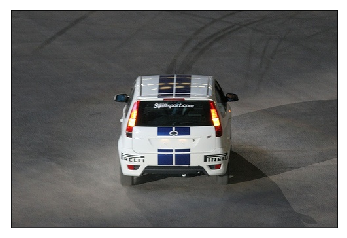

In [29]:
show_img(im)

In [30]:
from IPython.core.debugger import set_trace

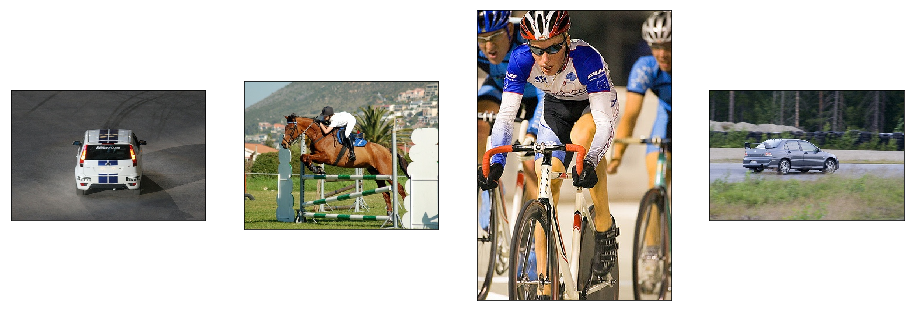

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
imgs = [open_image(PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'/trn_j[IMAGES][i][FILE_NAME]) for i in range(4)]

for img, ax in zip(imgs, axes.reshape(-1)):
    show_img(img, ax=ax)

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [32]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [33]:
trn_j[IMAGES][6]

{'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360}

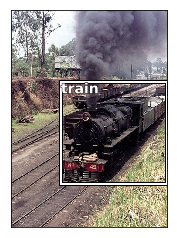

In [34]:
im = trn_j[IMAGES][6]
ary = open_image(IMG_PATH/im[FILE_NAME])
ax = show_img(ary)

anno = trn_anno[im[ID]]
b = bb_hw(anno[0][0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[anno[0][1]])

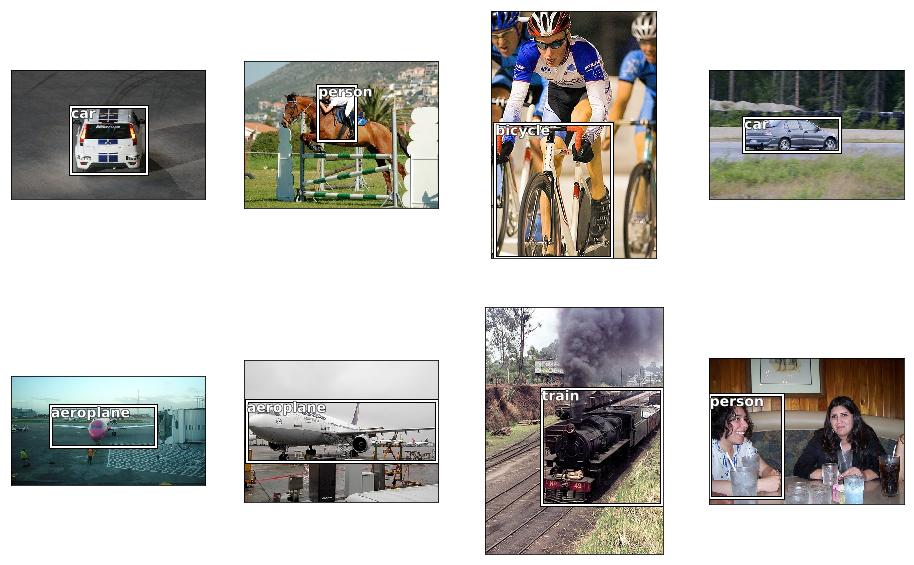

In [35]:
# Here I am just printing a single bbox per image. An image can contain more objects
# and the first bbox doesn't necessarily have to be the biggest.
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
imgs = [trn_j[IMAGES][i] for i in range(8)]

for im, ax in zip(imgs, axes.reshape(-1)):
    ary = open_image(IMG_PATH/im[FILE_NAME])
    ax = show_img(ary, ax=ax)

    anno = trn_anno[im[ID]]
    b = bb_hw(anno[0][0])
    draw_rect(ax, b)
    draw_text(ax, b[:2], cats[anno[0][1]])

In [36]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


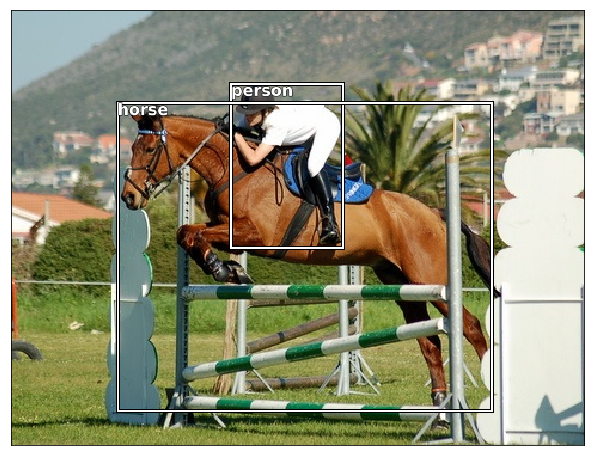

In [37]:
draw_idx(17)

## Largest item classifier

In [38]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [39]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [40]:
get_from_dict(trn_lrg_anno, 4)

{12: (array([ 96, 155, 269, 350]), 7),
 17: (array([ 77,  89, 335, 402]), 13),
 23: (array([  1,   2, 461, 242]), 15),
 26: (array([124,  89, 211, 336]), 7)}

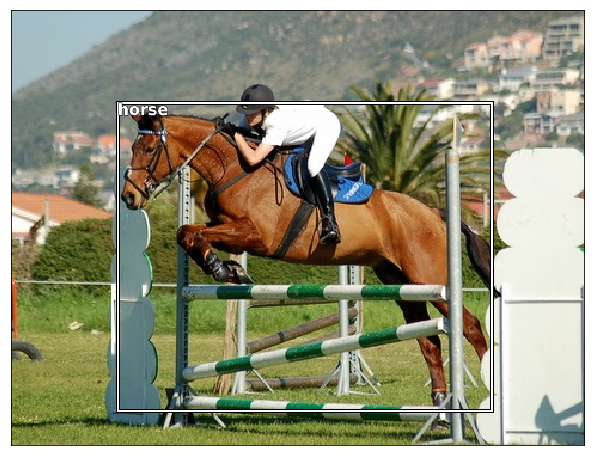

In [41]:
draw_im(open_image(IMG_PATH/trn_j[IMAGES][1][FILE_NAME]), [trn_lrg_anno[17]])

In [138]:
df = pd.DataFrame(
    {
        'fn': [trn_fns[idx] for idx in trn_ids],
        'cat': [cats[trn_lrg_anno[idx][1]] for idx in trn_ids]
    },
    columns=['fn', 'cat']
)

In [139]:
df.head()

fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [140]:
df.to_csv(PATH/'largest_item_classifier.csv', index=False)

In [141]:
f_model = resnet34
sz = 224
bs = 64

In [143]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, PATH/'largest_item_classifier.csv', bs, tfms)

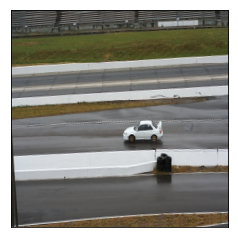

In [48]:
x,y=next(iter(md.trn_dl))
show_img(md.trn_ds.denorm(to_np(x))[0])

In [144]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [56]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:04<00:00,  6.32it/s, loss=12.6]


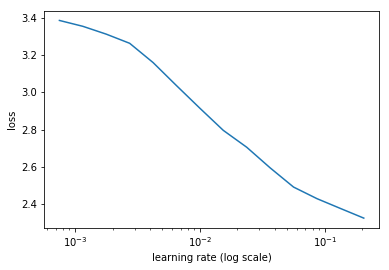

In [57]:
learn.sched.plot()

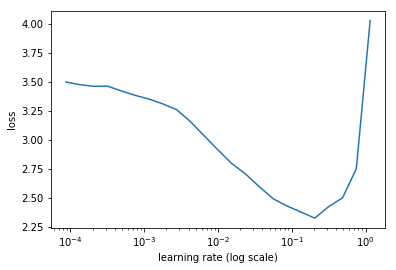

In [58]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [145]:
lr = 2e-2

In [146]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.233167   0.643663   0.811298  



[0.6436633, 0.8112980797886848]

In [147]:
lrs = np.array([lr/1000,lr/100,lr])

In [148]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:06<00:01,  4.38it/s, loss=3.86] 


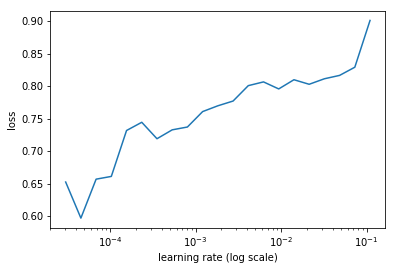

In [149]:
learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [150]:
lrs

array([0.00002, 0.0002 , 0.02   ])

In [151]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.824535   0.597887   0.826472  



[0.59788686, 0.8264723569154739]

In [152]:
learn.unfreeze()

In [153]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.623188   0.576455   0.828876  
    1      0.448184   0.553895   0.832782                  



[0.55389506, 0.8327824547886848]

In [154]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x))
x, preds  = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


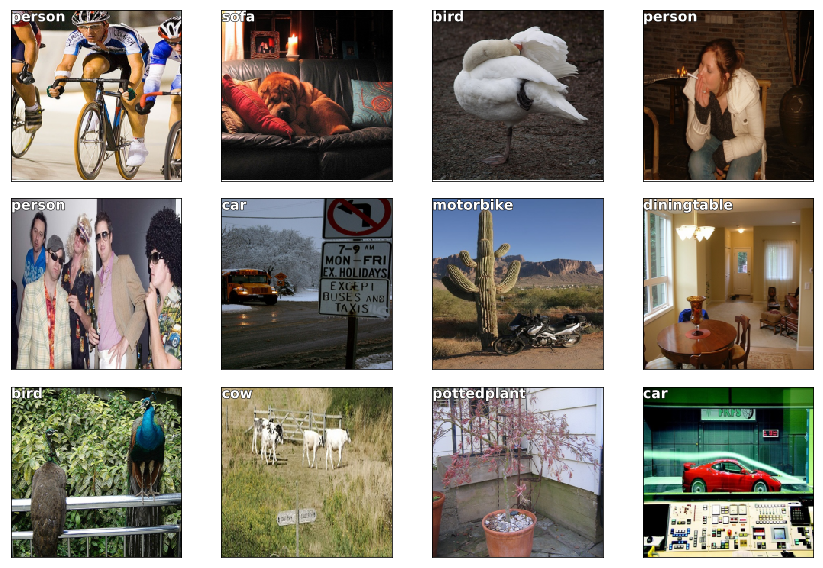

In [155]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

##  BBOX only

In [157]:
BB_CSV = PATH/'bb.csv'

In [161]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [162]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [163]:
f_model=resnet34
sz=224
bs=64

In [164]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [165]:
x,y=next(iter(md.val_dl))

In [167]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

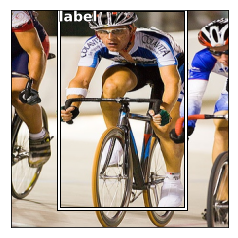

In [169]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [170]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:03<00:00,  7.73it/s, loss=476] 


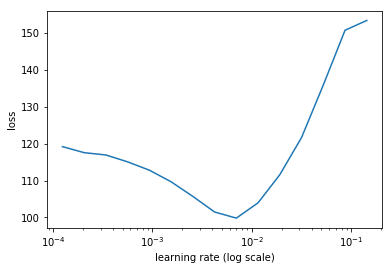

In [171]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [172]:
lr = 2e-3

In [173]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      49.890376  34.556461 
    1      37.341486  27.892723                           
    2      31.09201   27.246376                           



[27.246376]

In [174]:
lrs = np.array([lr/100,lr/10,lr])

In [175]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      63.172407  586914058993664.0



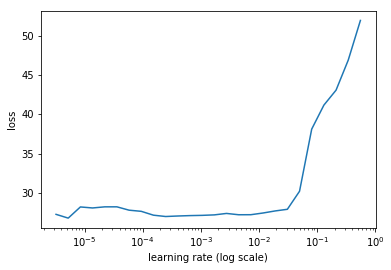

In [176]:
rf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [177]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.643352  23.497082 
    1      21.770016  22.304977                           
    2      17.645307  20.25816                            



[20.25816]

In [178]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


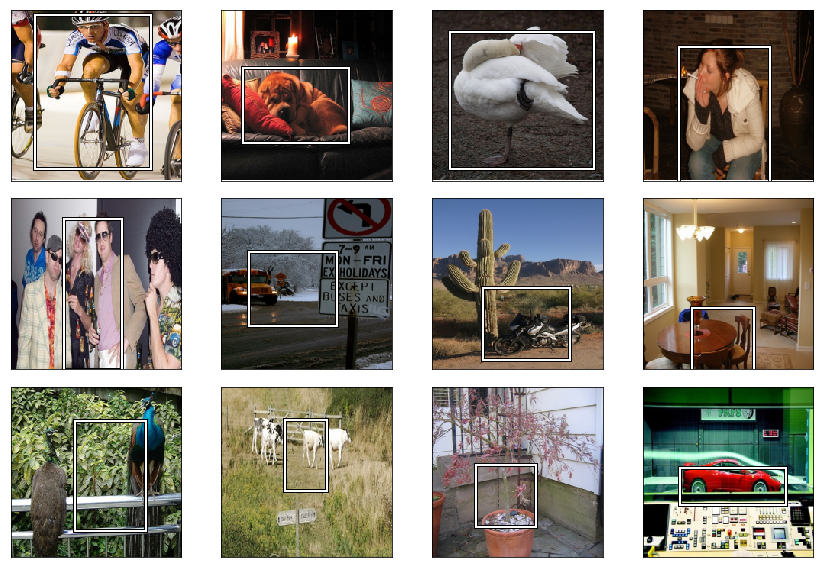

In [179]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

##  Single object detection

In [180]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [181]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [184]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, PATH/'largest_item_classifier.csv', tfms=tfms_from_model(f_model, sz))

In [186]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [187]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [188]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [189]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [190]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  1.,  63., 222., 159.], dtype=float32)

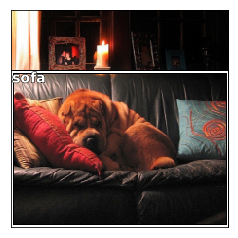

In [191]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [192]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [193]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:03<00:00,  8.50it/s, loss=892]


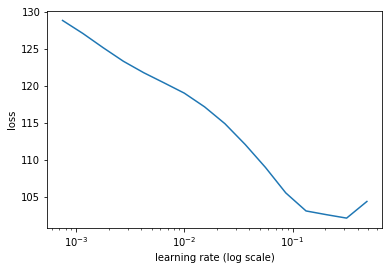

In [194]:
learn.lr_find()
learn.sched.plot()

In [195]:
lr=1e-2

In [196]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      74.215174  45.671173  0.797175   31.805226 
    1      52.187919  36.11602   0.828876   25.153476     
    2      41.834278  35.512115  0.823468   24.713045     



[35.512115, 0.8234675452113152, 24.71304488182068]

In [197]:
learn.freeze_to(-2)

In [198]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:05<00:00,  4.85it/s, loss=246] 


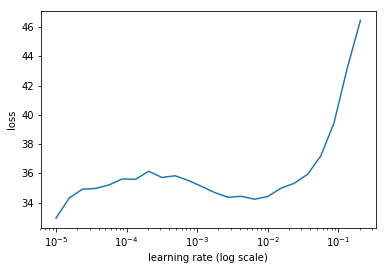

In [199]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [200]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.553565  35.00185   0.817308   23.139959 
    1      28.404957  32.727436  0.801683   20.884849     
    2      23.850346  32.271748  0.807542   20.460117     
    3      20.666241  31.419144  0.819261   19.743277     
    4      18.255003  30.989815  0.819261   19.680979     



[30.989815, 0.8192608207464218, 19.680978536605835]

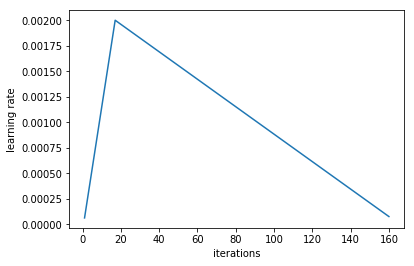

In [203]:
learn.sched.plot_lr()

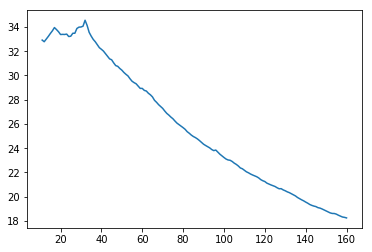

In [202]:
learn.sched.plot_loss()

In [204]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [205]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


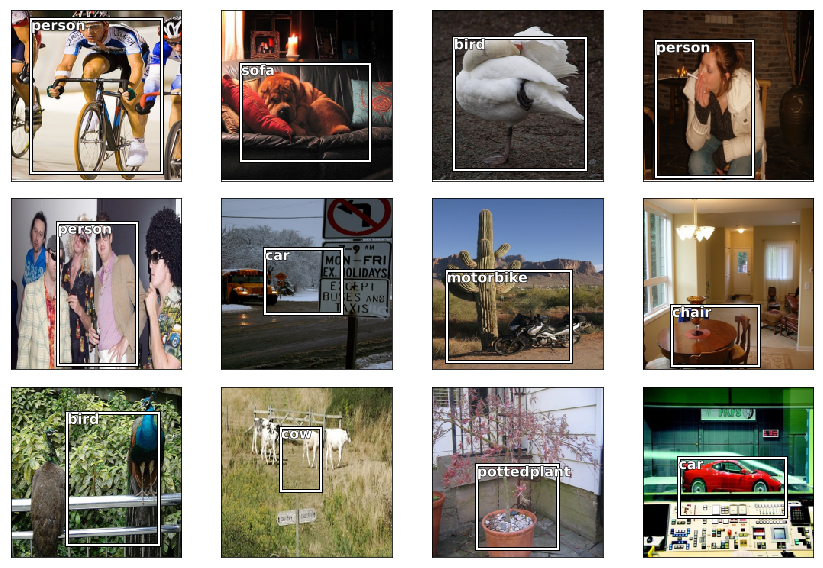

In [206]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()